In [1]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import jax
from jax import jit,vmap,grad
from jax import random
import numpy as np
import jax.numpy as jnp
from jax import vjp
from qutip import *
from jax.experimental import ode,optimizers
from jax.experimental.ode import odeint

from jax.config import config   
config.update("jax_enable_x64", True) # Force Jax use float64 as default Float dtype

from jax.tree_util import tree_unflatten,tree_flatten
from jax.test_util import check_grads # import jax implemented method to check the grads


N = 4 # set number of qubits as a global parameter
N1 = 10 #fourier series size
key = random.PRNGKey(42)

In [2]:
def normalize(psi):
    '''
    Normalize a given wavefunction
    '''
    return psi/jnp.linalg.norm(psi,axis=0,keepdims=True)

def generate_batch(U,key,batch_size=10,batch_num=3,*args):
    '''
    To generate a bach of data point given a unitary gate
    '''
    key_re , key_im = random.split(key)
    psi_batch = random.normal(key_re,shape=(2**N,batch_size,batch_num)) + 1j*random.normal(key_im,shape=(2**N,batch_size,batch_num))
    psi0_batch = jnp.einsum('ijk,li->ljk',psi_batch,U)
    #      initial psi          training data psi0
    return normalize(psi_batch), normalize(psi0_batch)

To perceed neural network, an ODE solver is needed. In our case is `scipy.integrate.solve_ivp`

In [3]:
def forward(t1,psi0,flat_p,func_method='matrix'):
    '''
    solver for Schrodinger equation with initial condition of psi0 and Hamiltonian in the interval of [0,t1]
    use mathod of scipy
    '''
    if func_method == 'function':
        Hz = lambda t,x: -1.0j*H(t,x,flat_p,t1)
    elif func_method == 'matrix':
        def Hz(t,x,*args): 
            t1,flat_p, = args
            return -1.0j*Hmat(t,x,flat_p,t1)
    else:
        raise NameError("wrong solver")
    
    sol = solve_ivp(Hz,[0,t1],psi0,t_eval=[0,t1],args=[t1,flat_p],method='RK45') # There are something wrong with the precision control in solve_ivp
    return sol.y[:,1]

In [4]:
def initial(key1 = None):
    '''
    Return randomized parameters
    '''
    if (key1).all() == None:
        return np.random.normal(size=(N1*(N+1)+1,))
    else:
        return random.normal(key1,shape=(N1*(N+1)+1,))

In [5]:
def n(i,x):
    '''
    number operator for n_i (x)
    '''
    return (x&2**i)/2**i

def unpackp(x):
    return jnp.array(x[:N1]) , jnp.array([x[(i+1)*N1:(i+2)*N1] for i in range(N)]), jnp.array(x[-1], dtype=jnp.float32)

def flatten(x):
    return 0 # TODO

Our Hamiltonian is $$\begin{aligned}
\frac{H}{\hbar}=& \frac{\Omega(t)}{2} \sum_{i=1}^{N} \sigma_{x}^{(i)}-\sum_{i=1}^{N} \Delta_{i}(t) n_{i} \\
&+\sum_{i<j} \frac{V}{|i-j|^{6}} n_{i} n_{j}
\end{aligned}$$

In [6]:
def H(t,psi,flat_p,t1):
    '''
    Using xor to implement off diagonal element
    '''
    D, = jnp.shape(psi)
    res = jnp.zeros(D,dtype=jnp.complex64)

    w = 2*jnp.pi/t1

    u_omega, u_d, V = unpackp(flat_p)
    omega = jnp.sum(jnp.array([u_omega[i]*jnp.sin(w*(i+1)*t) for i in range(N1)]))
    delta = [jnp.sum(jnp.array([u_d[j,i]*jnp.sin(w*(i+1)*t) for i in range(N1)])) for j in range(N)]
    
    for x in range(D):
        Ci = psi[x]
        diag = - jnp.sum(jnp.array([ delta[i]*n(i,x) for i in range(N)]))\
        + jnp.sum(jnp.array([[V*n(i,x)*n(j,x)/jnp.abs(i-j)**6 if i<j else 0 for i in range(N)] for j in range(N)])) #diagonal part of hamiltonian
        res = jax.ops.index_add(res, (x,), diag*Ci)
        cast = jnp.array([x^2**i for i in range(N)]) # ^ is for xor, to calculate the flip operation
        res = jax.ops.index_add(res, cast, omega*Ci/2)
    return res

For speed we use dense matrix to represent Hamiltonian

In [7]:
n0 = jnp.array([jnp.diag(jnp.array([n(i,x) for x in range(2**N)])) for i in range(N)]) #number operator matrix form n0[i] = n_i

print(n0.shape)
#print(jnp.matmul(n0[1],n0[2]))

def H_independent():
    '''
    Time independent part of Hamiltonian
    '''
    res = jnp.zeros((2**N,2**N))
    for i in range(N):
        for j in range(N):
            if j<= i: continue
            params = 1/np.abs(i-j)**6
            res += params*(jnp.dot(n0[i],n0[j]))
    return res
H1 = H_independent()
# print(jnp.trace(H1))

f = lambda x,y,i : 1 if y==x^2**i else 0
H2 = sum([jnp.array([[f(x,y,i) for x in range(2**N)] for y in range(2**N)]) for i in range(N)]) #checked

@jit
def Hmat(t,psi,flat_p,t1):
    '''
    Using dense matrix to represent Hamiltonian
    '''
    D, = jnp.shape(psi)
    res = jnp.zeros(D,dtype=jnp.complex64)
    
    w = 2*jnp.pi/t1
    
    u_omega, u_d, V = unpackp(flat_p)
    
    ft =jnp.array([jnp.sin(w*(i+1)*t) for i in range(N1)])

    omega = jnp.dot(u_omega,ft)
    delta = u_d@ft
    
    return (V*H1 + 0.5* omega* H2 - jnp.einsum('i,ijk->jk',delta,n0))@psi

(4, 16, 16)


In [8]:
@jit
def loss(psi,flat_p,t1,A,psi0):
    '''
    define the loss function, which is a pure function
    '''
    omega = 2*jnp.pi/t1
    l1 = 1 - jnp.abs(jnp.dot(jnp.conjugate(psi),psi0))**2 # Overlap
    
    u_omega, u_d, V = unpackp(flat_p)
    freqeuncy = jnp.array([i*omega**2 for i in range(N1)])
    l2 = 0.5*jnp.dot(jnp.conjugate(freqeuncy),u_omega**2)
#     l2 = 0.5*jnp.sum(jnp.array([ (i*omega*flat_p[i])**2 for i in range(N1)]))
    l3 = 0.5*jnp.sum(jnp.dot(u_d**2,jnp.conjugate(freqeuncy)))
#     l3 = 0.5*jnp.sum(jnp.array([ (i*omega*flat_p[i+N1])**2 for i in range(N1)]))
    l4 = 0.5*V**2
    
    l5 = t1**2 # Punish total time
    
    return A[0]*l1+A[1]*l2+A[2]*l3+A[3]*l4+A[4]*l5

In [9]:
def grad_all(psi1,psi0,flat_p,t1,A,method='matrix'):
    '''
    gradient with adjoint method
    return value and grad
    '''
    if method=='matrix':
        H_evol = Hmat
    elif method == 'function':
        H_evol = H
    else:
        raise NameError('Wrong dynamics')
        
    D, = jnp.shape(psi1)
    
    loss_val, a0 = jax.value_and_grad(loss, argnums=0)(psi1,flat_p,t1,A,psi0)

    pLt1 = jnp.array([jnp.dot(a0,H_evol(t1,psi1,flat_p,t1))])
    
    aug_state = jnp.concatenate([psi1, a0, -pLt1, jnp.zeros(((N+1)*N1+1,))])
    print(aug_state.shape)
    def unpack(x):
              # z , vjp_z   , vjp_t , vjp_args
        return x[:D], x[D:2*D], x[2*D], x[2*D+1:]
    
    def wrap_vjp(augment_state,t,parameters):
        Hz = lambda z : H_evol(t,z,parameters,t1)
        Ht = lambda t0 : H_evol(t0,augment_state[0],parameters,t1)
        Hp = lambda p : H_evol(t,augment_state[0],p,t1)
        _, vjp_funz = vjp(Hz, augment_state[0])
        _, vjp_funt = vjp(Ht, t)
        _, vjp_funp = vjp(Hp, flat_p)
        
        # vjp_funz(augment_state[1]) is a tuple
#         print(vjp_funz(augment_state[1])[0].shape,vjp_funp(augment_state[1])[0].shape,vjp_funt(augment_state[1])[0].shape)
        return [- vjp_funz(augment_state[1])[0],- vjp_funp(augment_state[1])[0],- vjp_funt(augment_state[1])[0]]
    
    def aug_dynamics(t,augment_state,*args):
        parameters, = args
        unpacked_aug_state = unpack(augment_state)

        vjps = wrap_vjp(unpacked_aug_state,t,parameters)
        aug_grad = jnp.concatenate([H_evol(t,unpacked_aug_state[0],parameters,t1), vjps[0], vjps[1], jnp.array([vjps[2]])])

        return aug_grad

    aug_state0 = solve_ivp(aug_dynamics,[t1,0],aug_state,t_eval=[t1,0],args=(flat_p,)) # Couldn't use jit for this, since it has no fixed memory.
    return loss_val, aug_state0.y[:,-1]

Our Hamiltonian is 

\begin{aligned}
\frac{H}{\hbar}=& \frac{\Omega(t)}{2} \sum_{i=1}^{N} \sigma_{x}^{(i)}-\sum_{i=1}^{N} \Delta_{i}(t) n_{i} \\
&+\sum_{i<j} \frac{V}{|i-j|^{6}} n_{i} n_{j}
\end{aligned}


In [10]:
def check_with_qutip(psi0,flat_p,t1):
    q_psi = Qobj(psi0,dims=[[2,2,2,2], [1 ,1,1,1]])

    t = np.linspace(0,t1,100)
    w = 2*jnp.pi/t1

    u_omega, u_d, V = unpackp(flat_p)
    
    ft = lambda t: jnp.array([jnp.sin(w*(i+1)*t) for i in range(N1)])
    omega = lambda t,args: jnp.dot(u_omega,ft(t))
    delta = lambda t,args: -u_d@ft(t)
    delta_func = [lambda t,args: delta(t,args)[i] for i in range(N1)]
#     omega = lambda t,args : jnp.sum(jnp.array([u_omega[i]*jnp.sin(w*(i+1)*t) for i in range(N1)]))
#     delta_func = [lambda t,args : - jnp.sum(jnp.array([u_d[j,i]*jnp.sin(w*(i+1)*t) for i in range(N1)])) for j in range(N)]
    h = []

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()
    ni = num(2)
    # time independent part
    h_list = []
    for i in range(N):
        for j in range(N):
            if j<= i: continue
            param = V/np.abs(i-j)**6
            op_list=[si for _ in range(N)]
            op_list[i] = ni
            op_list[j] = ni
            h_list.append(param*tensor(op_list))
    H0 = sum(h_list)
#     print(H0.tr()/V)
    h.append(H0)
    
    #time dependent part
    sx_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

    # construct the hamiltonian
    H1 = sum([0.5 * sx_list[n] for n in range(N)])
    h.append([H1,omega])

    for i in range(N):
        n_list = [si for _ in range(N)]
        n_list[i] = ni
        H2= tensor(n_list)
        h.append([H2,delta_func[i]])
    output = mesolve(h, q_psi, t, progress_bar = True)

    return output

Now we try to use `jax.experimental.ode.odeint` to autograd our function

In [29]:
@jit
def jax_fwd(psi_init,t1,flat_p,psi0,Loss_vec):
    '''
    Implement forward odeint with jax.experimental.ode.odeint
    
    psi_init: a batch of 
    
    return loss
    '''
    D,batch_size = jnp.shape(psi_init)
    
    def func(y,t,*args):
        t1,flat_p, = args
        return -1.0j*Hmat(t,y,flat_p,t1)
    t_set = jnp.linspace(0.,t1,5)
    
    res_list = []
    
    for i in range(batch_size):
        res = odeint(func,psi_init[:,i],t_set,t1,flat_p,rtol=1.4e-10, atol=1.4e-10)
        psi_final = res[-1,:]
        res_list.append(psi_final)

    return jnp.sum(jnp.array([loss(res_list[i],flat_p,t1,Loss_vec,psi0[:,i]) for i in range(batch_size)]))

def jax_fwd_psi(psi_init,t1,flat_p,psi0,Loss_vec):
    '''
    Same implement as jax_fwd
    Return wave fucntion, not batch
    '''
    
    D, = jnp.shape(psi_init)
    
    def func(y,t,*args):
        t1,flat_p, = args
        return -1.0j*Hmat(t,y,flat_p,t1)
    t_set = jnp.linspace(0.,t1,5)
    
    res = odeint(func,psi_init,t_set,t1,flat_p,rtol=1.4e-10, atol=1.4e-10)
    psi_final = res[-1,:]

    return psi_final

In [12]:
def q_optimize(data_batch,Loss_vector,flat_params,t1,learning_rate=1.,mass=0.9,num_steps=5):
    '''
    Train the neural ode over a given databatch
    '''
    psi_batch,psi0_batch = data_batch # we try with single wavefunction for instance
    
    D,batch_size,batch_num = jnp.shape(psi_batch)
    
#     opt_init, opt_update, get_params = optimizers.momentum(learning_rate,mass) # Use momentum as optimizer
    opt_init, opt_update, get_params = optimizers.adam(learning_rate) # Use adam optimizer
    loss_list = []
    def unpack(x):
          # t , args
        return x[0], x[1:]

    def step_fun(step, opt_state,psi,psi0):
#         value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state))
        aug_params = get_params(opt_state)

        t1,flat_params = unpack(aug_params)
#             res = forward(t1,psi,flat_params,method='matrix') # Forward with scipy RK45
#             value, grads = grad_all(res,psi0,flat_params,t1,Loss_vector) # grad with self 
#             opt_state = opt_update(step, jnp.real(grads[-L:]), opt_state)
        value,grads = jax.value_and_grad(jax_fwd,(1,2))(psi,t1,flat_params,psi0,Loss_vector)
        g_t, g_p = grads
        aug_grad = jnp.concatenate([jnp.array([g_t]),g_p])
        opt_state = opt_update(step,aug_grad,opt_state)
        return value, opt_state
    
    aug_params = jnp.concatenate([jnp.array([t1]),flat_params])
    opt_state = opt_init(aug_params)
    
    # optimize with mini_batch
    for step in range(num_steps):
        for i in range(batch_num):
            psi,psi0 = psi_batch[:,:,i],psi0_batch[:,:,i]
            value, opt_state = step_fun(step, opt_state,psi,psi0)
            loss_list.append(value)
            print('step {0} with batch {2}: loss is {1}'.format(step,value,i))
    plt.plot([x for x in range(num_steps*batch_num)],loss_list)
    return get_params(opt_state)

In [13]:
Test_gate_U = tensor([sigmax(),sigmax(),sigmax(),sigmax()]).full() # Take $\otimes simga_z^i$ as test unitary gate
# print(Test_gate_U.full())

step 0 with batch 0: loss is 2977.922088624734
step 0 with batch 1: loss is 2763.242316290945
step 0 with batch 2: loss is 2611.124571817826
step 1 with batch 0: loss is 2610.090185756202
step 1 with batch 1: loss is 2600.846688145419
step 1 with batch 2: loss is 2544.4700982246586
step 2 with batch 0: loss is 2418.4447103394205
step 2 with batch 1: loss is 2326.7152577813704
step 2 with batch 2: loss is 2262.998737830285
step 3 with batch 0: loss is 2227.0664918051743
step 3 with batch 1: loss is 2182.837334478275
step 3 with batch 2: loss is 2191.1998875587306
step 4 with batch 0: loss is 2185.6287045158497
step 4 with batch 1: loss is 2222.7046196621727
step 4 with batch 2: loss is 2201.864453979477
step 5 with batch 0: loss is 2171.5184565076115
step 5 with batch 1: loss is 2122.1955047854062
step 5 with batch 2: loss is 2144.747917320007
step 6 with batch 0: loss is 2140.1345651068677
step 6 with batch 1: loss is 2131.994013995772
step 6 with batch 2: loss is 2145.6453177742183
st

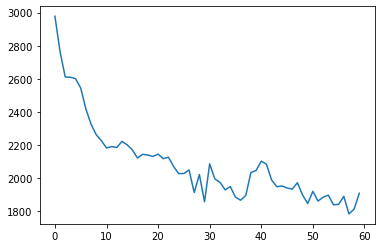

In [15]:
if __name__=='__main__':
    keypsi, keyinit = random.split(key)
    t1 = 10.
    Loss_vector = [100.,0.1,0.1,0.1,0.5]
    flat_params = initial(keyinit)
    data_batch= generate_batch(Test_gate_U,keypsi,batch_size=20,batch_num=3)
    res_state = q_optimize(data_batch,Loss_vector,flat_params,t1,learning_rate=1.,num_steps=20)

First we check different back propagation methods time

In [17]:
psi,psi0 = data_batch
t1 =10.
%time res = forward(t1,psi[:,0],flat_params,method='matrix')
%time loss_val, gd = grad_all(res,psi0[:,0],flat_params,t1,Loss_vector)  # grad_all(psi1,flat_p,t1,A,psi0)
print(loss_val)

psi,psi0 = generate_batch(Test_gate_U,keypsi,batch_size=1)
t1 =2.
%time res = forward(t1,psi[:,0],flat_params,method='matrix')
%time loss_val, gd = grad_all(res,psi0[:,0],flat_params,t1,Loss_vector)  # grad_all(psi1,flat_p,t1,A,psi0)

psi,psi0 = generate_batch(Test_gate_U,keypsi,batch_size=1)
t1 = 10.
%time val,gd_jax=jax_fwd(psi[:,0],t1,flat_params,psi0[:,0],Loss_vector)
print(val)

CPU times: user 303 ms, sys: 27.5 ms, total: 330 ms
Wall time: 336 ms
(84,)
CPU times: user 1min 10s, sys: 13.2 s, total: 1min 23s
Wall time: 1min 24s
6.091540803541452


Next we check our batch correctness

In [15]:
keypsi, keyinit = random.split(key)
psi_batch,psi0_batch = generate_batch(Test_gate_U,keypsi)
mode_psi = jnp.einsum('ijk,ijk->jk',psi_batch,psi_batch.conj())
mode_psi0 = jnp.einsum('ijk,ijk->jk',psi0_batch,psi0_batch.conj())

# print(mode_psi)
# print(mode_psi0)

And we check two different forward mode

In [102]:
psi = psi_batch[:,0,0]
psi0 = psi0_batch[:,0,0]

t1 = 10.
flat_params = initial(keyinit)
Loss_vector = [10.,0.1,0.1,0.1,0.5]

res_sci = forward(t1,psi,flat_params,func_method='matrix')
print(jnp.dot(res_sci.conj(),res_sci))
loss_sci = loss(psi,flat_params,t1,Loss_vector,psi0)
loss_jax= jax_fwd(psi,t1,flat_params,psi0,Loss_vector)

print(loss_sci) # not accurate
print(loss_jax)

(1.008947887506927-5.001847503832613e-18j)
64.74345324743116
64.76980975071014


After that we check with back propagation with `check_grads`

In [19]:
psi = psi_batch[:,:,0]
psi0 = psi0_batch[:,:,0]

t1 = 10.
flat_params = initial(keyinit)
Loss_vector = [10.,0.1,0.1,0.1,0.5]

jax_grad_check = lambda t1,p: jax_fwd(psi,t1,p,psi0,Loss_vector)
check_grads(jax_grad_check,(t1,flat_params),order=1,modes='rev') # No error thrown

In [25]:
psi = psi_batch[:,:,2]
psi0 = psi0_batch[:,:,2]
print(psi.shape)

t1 = 10.
flat_params = initial(keyinit)
Loss_vector = [10.,0.1,0.1,0.1,0.]

%time value,grads = jax.value_and_grad(jax_fwd,(1,2))(psi,t1,flat_params,psi0,Loss_vector)

(16, 10)
CPU times: user 38.9 ms, sys: 0 ns, total: 38.9 ms
Wall time: 39.1 ms


In [ ]:
t , flat_p = res_state[0], res_state[1:]
psi_batch,psi0_batch = data_batch
psi = psi_batch[:,0,0]
psi0 = psi0_batch[:,0,0]
res = jax_fwd_psi(psi,t,flat_p,psi0,Loss_vector)

In [34]:
print(jnp.abs(jnp.dot(psi.conj(),psi0)))
print(jnp.abs(jnp.dot(res.conj(),psi0)))

0.1616530764456663
0.4699948524768668
